Welcome to our tutorial, where we will guide you through how to use our package. In this guide, you'll learn the following key steps:

1.Create a Hetero Dirichlet 0.8 split of CIFAR-10.
2.Initialize federated learning for both client and server.
3.Start the training process.
4.Visualize the results.

# Package importation

In [2]:
import serverFL.Server_FLASHRL as Server_FLASHRL 
import serverFL.BEFL_offline as BEFL_offline
import serverFL.Server_FedProx as Server_FedProx
import serverFL.Server_Proposed_AFL as Server_Proposed_AFL
import serverFL.Server_AFL as Server_AFL
import serverFL.Server_TIFL as Server_TIFL
import serverFL.Server_FEDAVG as Server_FEDAVG
import serverFL.Server_FAVOR as Server_FAVOR
import serverFL.Server_Proposed_offline as Server_Proposed_offline

import torchvision
import json
from torchvision import datasets, transforms
import data_manipulation.Data_distribution as Data_distribution

from fedlab.utils.dataset import CIFAR10Partitioner
from fedlab.utils.functional import partition_report
import models.CIFAR10.CNN as CNN

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
import timeit
import pickle
import torch

import prints.result_plot as result_plot

# Creation of a non-iid division of CIFAR-10

We'll begin by demonstrating how to create a Hetero Dirichlet 0.8 division of the CIFAR-10 dataset using the FedLab framework

In [3]:
# Define a transformation to normalize CIFAR-10 images
trans_cifar = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values to range [-1, 1]
])

# CIFAR-10 training dataset
dataset_train = datasets.CIFAR10('data/cifar10/', train=True, download=True, transform=trans_cifar)

# CIFAR-10 testing dataset
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar)

# Display dataset information
print("Number of training samples: ", len(dataset_train))


Files already downloaded and verified
Files already downloaded and verified
Number of training samples:  50000


In [4]:
# Create the data division
from fedlab.utils.dataset import MNISTPartitioner

db = Data_distribution.Data_distribution(dataset_train, 100)

num_clients = 100
seed = 40
num_classes = 10

client_index_non_iid_100_fedlab = CIFAR10Partitioner(dataset_train.targets, 
                                100,
                                balance=None, 
                                partition="dirichlet",
                                dir_alpha=0.5,
                                seed=seed)

# generate partition report
csv_file = "./partition-reports/Cifar_heterdirichlet_08.csv"
partition_report(dataset_train.targets, client_index_non_iid_100_fedlab.client_dict, 
                 class_num=num_classes, 
                 verbose=False, file=csv_file)

col_names = [f"class{i}" for i in range(num_classes)]

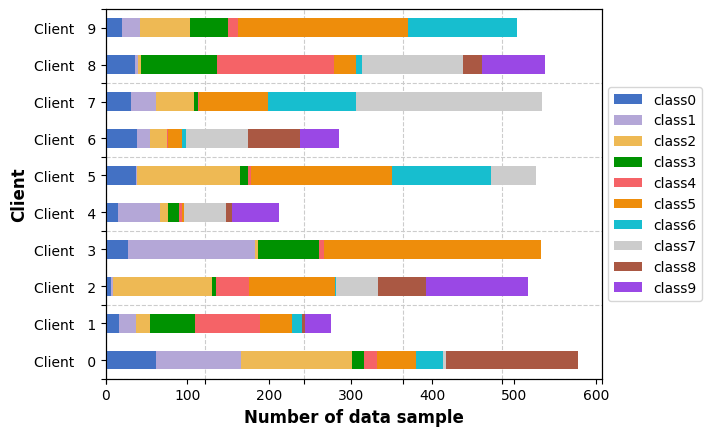

In [5]:
# Print the data distribution

client_index_non_iid_100_fedlab_df = pd.read_csv(csv_file,header=1)
client_index_non_iid_100_fedlab_df = client_index_non_iid_100_fedlab_df.set_index('client')
for col in col_names:
    client_index_non_iid_100_fedlab_df[col] = (client_index_non_iid_100_fedlab_df[col] * client_index_non_iid_100_fedlab_df['Amount']).astype(int)
    
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the distribution for the specific clients on the new axis
colors = ['#4371C4', '#B4A7D7', '#EEB954', '#009201','#F56367' , '#ee8d0b', '#17BECF','#CCCCCC', '#AA5843','#9a48e5']

#specific_client_data.plot.barh(stacked=True, ax=ax, color=colors)

client_index_non_iid_100_fedlab_df[col_names][:10].plot.barh(stacked=True, ax=ax, color=colors)  

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set x-label and y-label
ax.set_xlabel('Number of data sample', fontsize=12, fontweight='semibold')
ax.set_ylabel('Client', fontsize=12, fontweight='semibold')


# Add a transparent axis for grid lines on the same figure
ax_grid = ax.inset_axes([0, 0, 1, 1], transform=ax.transAxes, zorder=-1)
ax_grid.grid(True, color='#CCCCCC', linestyle='--')

ax_grid.set_xticklabels([])
ax_grid.set_yticklabels([])

# Save the figure with the plot and grid lines
plt.savefig(f"images/Cifar_10_selected.pdf", dpi=400, bbox_inches='tight')

plt.show()  # Show the plot

In [6]:
col_names = [f"class{i}" for i in range(num_classes)]
list_label = []
for x in np.array(client_index_non_iid_100_fedlab_df[col_names]):
    list_label.append(np.where(x > 0)[0])
dict_users = db.division_noniid_fedlab(client_index_non_iid_100_fedlab.client_dict.values(), list_label)
with open('data_division/CIFAR10/CIFAR10_dict_hetero_dirichlet08.pkl', 'wb') as handle:
    pickle.dump(dict_users, handle, protocol=pickle.HIGHEST_PROTOCOL)
# Read clients' information from stored files

# Load the dictionary containing client data from a pickle file
with open('data_division/CIFAR10/CIFAR10_dict_hetero_dirichlet08.pkl', 'rb') as f:
    Dict_users = pickle.load(f)

100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


# Load Client config

In [7]:
import json

# Initialize the columns dictionary
columns = { 
    "N0": [], # Power spectral density of Gaussian noise
    "PK": [], # Transmission power
    "f": [], # CPU frequency
    "CpuCycle": [], # CPU cycles needed for one sample
    "X": [], # Capacitance
    "B": [], # Bandwidth
    "gk": [], # Channel gain
    "cores": [], # Number of cores
    "battery": [] # Battery capacity
}

# Open and read the contents of config.json
with open('config.json', 'r') as file:
    content = file.read()

# Combine multiple JSON objects into an array format
json_content = "[" + content.replace("}{", "},{") + "]"
data_list = json.loads(json_content)
rr=[]
index=0
# Iterate over each dictionary object and add its values to the corresponding column lists
for record in data_list:
    columns["N0"].append(record["N0"])
    columns["PK"].append(record["PK"])
    columns["f"].append(record["f"])
    columns["CpuCycle"].append(record["CpuCycle"] * 100)
    columns["X"].append(record["X"] / 1000)
    columns["B"].append(30)
    columns["cores"].append(record.get("cores", 0))
    if index%20==0:
        print(set(rr))
        rr=[]
    rr.append(record.get("CPU", 0))
    index+=1
print(set(rr))
# Read config2.json file line by line and update columns["gk"]
with open('config2.json', 'r') as file:
    for line in file:
        record = json.loads(line.strip())  # Parse JSON object line by line
        gk_value = record["gk"]
        columns["gk"].append(gk_value)

# Read config3.json file line by line and update columns["battery"]
with open('config3.json', 'r') as file:
    for line in file:
        record = json.loads(line.strip())  # Parse JSON object line by line
        columns["battery"].append(record["battery"] * record["n"])

# Convert the columns dictionary into a list of tuples (clients_info)
clients_info = list(zip(columns["N0"], columns["PK"], columns["f"], 
                        columns["CpuCycle"], columns["X"], columns["B"],
                        columns["gk"], columns["cores"], columns["battery"]))

# Print or use the first client information
print(clients_info[0])


set()
{'Apple A16 Bionic', 'MediaTek Dimensity 9200', 'Qualcomm Snapdragon 8 Gen 1'}
{'Apple A15 Bionic', 'Qualcomm Snapdragon Wear 4100', 'Apple S7', 'Qualcomm Snapdragon 7c', 'Apple M1'}
{'Qualcomm Snapdragon Wear 4100', 'MediaTek MT2601', 'NVIDIA Jetson Xavier NX', 'Apple S7', 'Renesas R-Car H3', 'Qualcomm Snapdragon 820A'}
{'Intel Core i5-1240P', 'Intel Core i7-12700H', 'NVIDIA Jetson Xavier NX', 'AMD Ryzen 7 5800U', 'Renesas R-Car H3', 'Qualcomm Snapdragon 820A'}
{'Intel Core i7-12700H', 'Intel Core i5-1240P', 'AMD Ryzen 7 5800U'}
(1e-21, 0.1, [3442438728.960779, 3420832186.062498, 3455643528.593351, 3469168044.3582544, 3425799868.8687024, 3446578966.421084, 3460712266.603226, 3428226129.606779, 3441838885.854311, 3479591131.2064476, 3412841559.9713535, 3434384787.961169, 3411836119.3288918, 3461035892.196034, 3446273561.025089, 3433887663.107139, 3456188770.736782, 3433497784.1447706, 3445131254.8220334, 3442022471.4235697, 3454078455.7044077, 3473045865.4157486, 3456928390.97622

In [8]:
# Structure the non-iid division
list_label = []
for x in np.array(client_index_non_iid_100_fedlab_df[col_names]):
    list_label.append(np.where(x > 0)[0])
    
dict_users = db.division_noniid_fedlab(client_index_non_iid_100_fedlab.client_dict.values(), list_label)
# Save the non-idd data division
with open('data_division/CIFAR10/CIFAR10_dict_hetero_dirichlet08.pkl', 'wb') as handle:
    pickle.dump(dict_users, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


# Client and server FL initialization 

In [10]:
# Read clients' information from stored files

# Load the dictionary containing client data from a pickle file
with open('data_division/CIFAR10/CIFAR10_dict_hetero_dirichlet08.pkl', 'rb') as f:
    Dict_users = pickle.load(f)

# Load lists containing clients' names, cores, frequencies, and bandwidths from respective pickle files
# with open("clients_info/CIFAR10/names_list.pkl", "rb") as file:
#     name_list = pickle.load(file)

# Calculate the number of samples for each client
number_samples = []
for key in Dict_users.keys():
    number_samples.append(len(Dict_users[key]))


In [ ]:
# Load the pre-trained model for CIFAR10 from a saved file
model_CIFAR10 = torch.load("models_saved/CIFAR10/CNNmodel.pt")

# Initialize the FL server with specific parameters
Server_AFL = Server_AFL.Server_AFL(
    num_clients=100,  # Number of clients participating in Federated Learning
    global_model=model_CIFAR10,  # Global model
    dict_clients=Dict_users,  # Dictionary containing clients data
    loss_fct=torch.nn.CrossEntropyLoss(),  # Loss function for training
    B=50,  # Local batch size for training on each client
    dataset_test=dataset_test,  # Testing dataset for evaluation
    learning_rate=0.01,  # Learning rate for training
    momentum=0.9,  # Momentum value for optimization
    clients_info=clients_info,  # Information about clients (names, num_samples, cores, etc.)
    bandwidth=10000000
) 

In [ ]:
# Perform Federated Learning training on the initialized server

# Initiate the Federated Learning training process on the server
results2 = Server_AFL.global_train(
    comms_round=100,  # Number of communication rounds for training
    C=0.1,  # Fraction of clients selected to participate in each training round
    E=5,  # Number of local epochs for each client's training
    mu=0,  # FedProx hyperparameter (by default = 0)
    batch_size=50,  # Batch size used in each local training iteration
    verbose_test=1,  # Verbosity level for test results (e.g., showing test accuracy)
    verbos=0, # Verbosity level for training process (e.g., printing progress)
    lamb=0.6,
    rep_init=1 / 100
)

In [ ]:
# Load the pre-trained model for CIFAR10 from a saved file
model_CIFAR10 = torch.load("models_saved/CIFAR10/CNNmodel.pt")

# Initialize the FL server with specific parameters
Server_offline = BEFL_offline.BEFL_offline(
    num_clients=100,  # Number of clients participating in Federated Learning
    global_model=model_CIFAR10,  # Global model
    dict_clients=Dict_users,  # Dictionary containing clients data
    loss_fct=torch.nn.CrossEntropyLoss(),  # Loss function for training
    B=50,  # Local batch size for training on each client
    dataset_test=dataset_test,  # Testing dataset for evaluation
    learning_rate=0.01,  # Learning rate for training
    momentum=0.9,  # Momentum value for optimization
    clients_info=clients_info,  # Information about clients (names, num_samples, cores, etc.)
    bandwidth=10000000,
    alpha=0.5
) 

In [ ]:
# Perform Federated Learning training on the initialized server

# Initiate the Federated Learning training process on the server
results = BEFL_offline.global_train(
    comms_round=50,  # Number of communication rounds for training
    C=0.1,  # Fraction of clients selected to participate in each training round
    E=5,  # Number of local epochs for each client's training
    mu=0,  # FedProx hyperparameter (by default = 0)
    batch_size=50,  # Batch size used in each local training iteration
    verbose_test=1,  # Verbosity level for test results (e.g., showing test accuracy)
    verbos=0, # Verbosity level for training process (e.g., printing progress)
    lamb=0.6,
    rep_init=1 / 100
)

In [ ]:
# Load the pre-trained model for CIFAR10 from a saved file
model_CIFAR10 = torch.load("models_saved/CIFAR10/CNNmodel.pt")

# Initialize the FL server with specific parameters
Serveur_FLASHRL = Server_FLASHRL.Server_FLASHRL(
    num_clients=100,  # Number of clients participating in Federated Learning
    global_model=model_CIFAR10,  # Global model
    dict_clients=Dict_users,  # Dictionary containing clients data
    loss_fct=torch.nn.CrossEntropyLoss(),  # Loss function for training
    B=50,  # Local batch size for training on each client
    dataset_test=dataset_test,  # Testing dataset for evaluation
    learning_rate=0.01,  # Learning rate for training
    momentum=0.9,  # Momentum value for optimization
    clients_info=clients_info,  # Information about clients (names, num_samples, cores, etc.)
    bandwidth=1e07
)

In [ ]:
results = Serveur_FLASHRL.global_train(
    comms_round=20,  # Number of communication rounds for training
    C=0.1,  # Fraction of clients selected to participate in each training round
    E=5,  # Number of local epochs for each client's training
    mu=0,  # FedProx hyperparameter (by default = 0)
    lamb=0.6,  # Past contribution factor
    rep_init=1 / 100,  # Initial reputation value)
    batch_size=50,  # Batch size used in each local training iteration
    verbose_test=1,  # Verbosity level for test results (e.g., showing test accuracy)
    verbos=0  # Verbosity level for training process (e.g., printing progress)
)

In [ ]:
# Load the pre-trained model for CIFAR10 from a saved file
model_CIFAR10 = torch.load("models_saved/CIFAR10/CNNmodel.pt")

# Initialize the FL server with specific parameters
Server_FAVOR = Server_FAVOR.Server_FAVOR(
    num_clients=100,  # Number of clients participating in Federated Learning
    global_model=model_CIFAR10,  # Global model
    dict_clients=Dict_users,  # Dictionary containing clients data
    loss_fct=torch.nn.CrossEntropyLoss(),  # Loss function for training
    B=50,  # Local batch size for training on each client
    dataset_test=dataset_test,  # Testing dataset for evaluation
    learning_rate=0.01,  # Learning rate for training
    momentum=0.9,  # Momentum value for optimization
    clients_info=clients_info,  # Information about clients (names, num_samples, cores, etc.)
    bandwidth=10000000
) 

In [ ]:
# Perform Federated Learning training on the initialized server

# Initiate the Federated Learning training process on the server
results = Server_FAVOR.global_train(
    comms_round=1,  # Number of communication rounds for training
    C=0.1,  # Fraction of clients selected to participate in each training round
    E=5,  # Number of local epochs for each client's training
    mu=0,  # FedProx hyperparameter (by default = 0)
    batch_size=50,  # Batch size used in each local training iteration
    verbose_test=1,  # Verbosity level for test results (e.g., showing test accuracy)
    verbos=0, # Verbosity level for training process (e.g., printing progress)
    M=0.5,
    omega=0.5
)

In [ ]:
# Load the pre-trained model for CIFAR10 from a saved file
model_CIFAR10 = torch.load("models_saved/CIFAR10/CNNmodel.pt")

# Initialize the FL server with specific parameters
Server_FedProx = Server_FedProx.Server_FedProx(
    num_clients=100,  # Number of clients participating in Federated Learning
    global_model=model_CIFAR10,  # Global model
    dict_clients=Dict_users,  # Dictionary containing clients data
    loss_fct=torch.nn.CrossEntropyLoss(),  # Loss function for training
    B=50,  # Local batch size for training on each client
    dataset_test=dataset_test,  # Testing dataset for evaluation
    learning_rate=0.01,  # Learning rate for training
    momentum=0.9,  # Momentum value for optimization
    clients_info=clients_info,  # Information about clients (names, num_samples, cores, etc.)
    bandwidth=10000000
) 

In [ ]:
# Perform Federated Learning training on the initialized server

# Initiate the Federated Learning training process on the server
results = Server_FedProx.global_train(
    comms_round=1,  # Number of communication rounds for training
    C=0.1,  # Fraction of clients selected to participate in each training round
    E=5,  # Number of local epochs for each client's training
    mu=0.1,  # FedProx hyperparameter (by default = 0)
    rep_init=1 / 100,  # Initial reputation value)
    verbose_test=1,  # Verbosity level for test results (e.g., showing test accuracy)
    verbos=0  # Verbosity level for training process (e.g., printing progress)
)

In [ ]:
# Load the pre-trained model for CIFAR10 from a saved file
model_CIFAR10 = torch.load("models_saved/CIFAR10/CNNmodel.pt")

# Initialize the FL server with specific parameters
Server_FEDAVG = Server_FEDAVG.Server_FEDAVG(
    num_clients=100,  # Number of clients participating in Federated Learning
    global_model=model_CIFAR10,  # Global model
    dict_clients=Dict_users,  # Dictionary containing clients data
    loss_fct=torch.nn.CrossEntropyLoss(),  # Loss function for training
    B=50,  # Local batch size for training on each client
    dataset_test=dataset_test,  # Testing dataset for evaluation
    learning_rate=0.01,  # Learning rate for training
    momentum=0.9,  # Momentum value for optimization
    clients_info=clients_info,  # Information about clients (names, num_samples, cores, etc.)
    bandwidth=10000000
)

In [ ]:
# Perform Federated Learning training on the initialized server

# Initiate the Federated Learning training process on the server
results = Server_FEDAVG.global_train(
    comms_round=1,  # Number of communication rounds for training
    C=0.1,  # Fraction of clients selected to participate in each training round
    E=5,  # Number of local epochs for each client's training
    mu=0,  
    rep_init=1 / 100,  # Initial reputation value)
    verbose_test=1,  # Verbosity level for test results (e.g., showing test accuracy)
    verbos=0  # Verbosity level for training process (e.g., printing progress)
)

# Results

In [ ]:
# Initialize an object of the plot class to visualize results
print_result = result_plot.result_plot()

In [ ]:
# Obtain the max accuracy values and corresponding training rounds for plotting
maxaccuracy_flash_rl, traininground_flash_rl = print_result.assendante_list(results['Accuracy'])

# Plotting the max accuracy per training round

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Add gridlines to the plot
ax.grid(True, color='#CCCCCC', linestyle='--')

# Plot the accuracy values per the training rounds for FLASH-RL
ax.plot(traininground_flash_rl, maxaccuracy_flash_rl, color="#4371C4", label="FLASH-RL", linestyle='dashdot')

# Set the linewidth for the plot axes
ax.spines['bottom'].set_linewidth(1)  # x-axis
ax.spines['left'].set_linewidth(1)  # y-axis

# Add a legend and labels for better visualization understanding
ax.legend()
ax.set_xlabel("Training round")
ax.set_ylabel("Accuracy (%)")

# Display the plot
plt.show()

Please note that as the number of training rounds increases, the results tend to improve, enabling the RL agent to converge towards the optimal clients.

In [ ]:
# Obtain the cumulative latency values for plotting
latence_cum_flashrl = print_result.cummulative_list(results['Timeurounds'])

# Plotting the end-to-end latency per training round

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Add gridlines to the plot
ax.grid(True, color='#CCCCCC', linestyle='--')

# Plot the cumulative latency values against the training rounds for FLASH-RL
ax.plot(range(0, len(latence_cum_flashrl)), latence_cum_flashrl, color="#4371C4", label="FLASH-RL", linestyle='dashdot')

# Set the linewidth for the plot axes
ax.spines['bottom'].set_linewidth(1)  # x-axis
ax.spines['left'].set_linewidth(1)  # y-axis

# Add a legend and labels for better visualization understanding
ax.legend()
ax.set_xlabel("Training round")
ax.set_ylabel("Latence (s)")

# Display the plot
plt.show()


Please note that as the number of training rounds increases, the results tend to improve, enabling the RL agent to converge towards the optimal clients.

In [ ]:
# Create a figure for the plot
plt.figure(figsize=(12, 6))

# Add gridlines to the plot
plt.grid(True, color='#CCCCCC', linestyle='--')

# Create a histogram of reputation values
plt.hist(results['Reputation'][10], bins=20, color="#4371C4", edgecolor='black', linewidth=2)

# Add a vertical line at x=0.1 to show the separation between -4 to 0 and 0.1 to 1
plt.axvline(x=0.1, color='#ee8d0b', linestyle='dashed', linewidth=2.5)

# Add labels and title
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
# plt.title('Distribution of reputation values')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# 数据
categories = []

for i in range(1,101):
    categories.append(i)
plt.ylim(0, 0.15)

values = [0.0032861034331773988, 0.004120144937523183, 0.00326767935809729, 0.006549735245386587, 0.007446475372890551, 0.01539819649597566, 0.0036418845238547423, 0.009684058273957814, 0.004447994683124434, 0.004624999151243151, 0.006569843317787813, 0.004775769253147136, 0.010876268126386925, 0.005321225207536698, 0.008520245769129681, 0.006200154430094586, 0.009936473097560156, 0.004800770826474912, 0.009970623053077825, 0.010500552969298615, 0.006978212624491182, 0.002031254332072036, 0.004780673059396297, 0.005314411920070228, 0.0036139021559941135, 0.004025913403837587, 0.0032704141168855092, 0.002096281452620926, 0.004107560433259191, 0.002752388047058785, 0.002659125457694141, 0.002002154104681282, 0.006594782230405292, 0.0038801200039466064, 0.005351729657183142, 0.004335617284751917, 0.006604717374466668, 0.0021230654092616345, 0.0015189254876601661, 0.0009961150138206951, 0.00658021366153842, 0.007385325452053175, 0.006735027467311408, 0.006258189086456937, 0.009322881150243927, 0.0069423287431319885, 0.007269711083011424, 0.006299295545255291, 0.003833645960877535, 0.005922847621767763, 0.008176382229957126, 0.005037129002279976, 0.005173745934812429, 0.006849580342697481, 0.0051730982889837, 0.008030513893080682, 0.009823369121442757, 0.03301000062088163, 0.03934788345774085, 0.024907640242029617, 0.008979996702039892, 0.013131885438257364, 0.011558345805443248, 0.007241555477722856, 0.012131296947074524, 0.00803034010682366, 0.008461255536104911, 0.015700662037145707, 0.008033461182962158, 0.011876848938315738, 0.008938408152791597, 0.0076703164224436885, 0.0065746107588260565, 0.015921761654059032, 0.013358995340824152, 0.006973586096405985, 0.02383695786403605, 0.04774109229168385, 0.01746952518508992, 0.017380556541092614, 0.012771674466007446, 0.014167605105070239, 0.014400659223946389, 0.019541381355538727, 0.004586580984325383, 0.0071435348558475074, 0.013266101227882533, 0.007662107235879996, 0.00623481241780502, 0.009962799151870108, 0.009768924342115902, 0.010442952470463925, 0.021399375229476717, 0.008686886265006286, 0.006033368644210343, 0.012415001980592193, 0.02530022152783046, 0.007537310232909867, 0.008359187690061762, 0.014890060591787924]
plt.bar(categories, values, color='green')

# 添加标题和标签
plt.title('Load distribution chart')
plt.xlabel('Client number')
plt.ylabel('Total relative energy consumption (KJ/mAh)')

# 显示图形
plt.savefig("comsuption_ours_iid.png")